# Machine Learning Final

## Setup

In [37]:
# import necessary libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [38]:
# update filename as necessary
filename = 'WFHdata_January24.csv'

In [39]:
# Load the dataset (10s)
data = pd.read_csv(filename)

/var/folders/g8/hyx6dk9d4c3879rk8zb7jw880000gn/T/ipykernel_36468/2994938657.py:2: DtypeWarning: Columns (373,383,458) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename)


## Data Cleaning

In [60]:
# Create a dataframe that only contains only quantitative variables
data_quant = data.select_dtypes(exclude=['object']) # length = 601

# Drop workstatus_current
data_quant = data_quant.drop(columns=['cratio100','icratio100','cratio100_nw','icratio100_nw',
                                      'workstatus_current','wfhcovid_ever','wfhcovid_frac',
                                      'ioneyearahead','iextratime_new','ilowquality',
                                      'numwfh_days_postCOVID_s_u','numwfh_days_postCOVID_boss_s_u',
                                      'wfh_days_postCOVID_s','wfh_days_postCOVID_ss',
                                      'wfh_days_postCOVID_boss','wfh_days_postCOVID_boss_ss'])

# Initialize length and optimal threshold
max_len = 0
max_vars = 0
optimal_threshold = 0

# Create lists to store data for plotting
threshold_values = []
len_dropped_values = []
num_vars_values = []

# Iterate over 100 threhold values to find the one the maximizes number of variables without length going to zero (40s)
for threshold in range(0, 101):
    threshold /= 100  # Convert to percentage
    missing_values = data_quant.isnull().mean()
    variables_to_drop = missing_values[missing_values > threshold].index
    data_cleaned = data_quant.drop(columns=variables_to_drop)
    data_dropped = data_cleaned.dropna()
    len_dropped = len(data_dropped)
    num_vars = len(data_dropped.columns)
    
    # If the number of observations is greater than zero, update optimal threshold and update max values
    if len_dropped > 0:
        optimal_threshold = threshold
        max_len = len_dropped
        max_vars = num_vars

        # Save the optimal dataframe
        data_optimal = data_dropped

    # Append the calculated values to the lists
    threshold_values.append(threshold)
    len_dropped_values.append(len_dropped)
    num_vars_values.append(num_vars)

# Print the optimal threshold and max values
print("Optimal threshold:", optimal_threshold)
print("Number of observations:", max_len)
print("Number of variables:", max_vars)

Optimal threshold: 0.46
Number of observations: 11908
Number of variables: 96


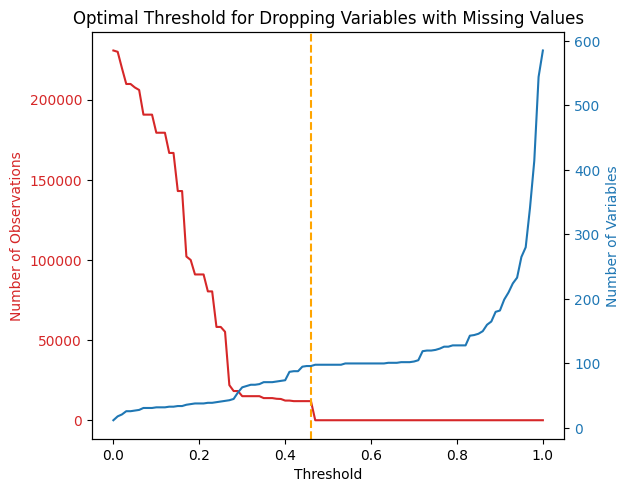

In [61]:
# Create the plot
fig, ax1 = plt.subplots()

# Y-axis 1 plots Number of Observations over Threshold
color = 'tab:red'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of Observations', color=color)
ax1.plot(threshold_values, len_dropped_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Y-axis 2 plots Number of variabels over Threshold
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Number of Variables', color=color)  
ax2.plot(threshold_values, num_vars_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add a dotted vertical line at the optimal threshold
ax1.axvline(x=optimal_threshold, color='orange', linestyle='--', label='Optimal Threshold')

# Show the plot
fig.tight_layout()  
plt.title('Optimal Threshold for Dropping Variables with Missing Values')
plt.show()

## OLS Regression

In [62]:
# Single out the outcome variable
y = data_optimal['wfhcovid']

# Create the dataframe with the outcome variable dropped
X = data_optimal.drop(columns=['wfhcovid'])

# Create training and testing dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1680)

# Fit the OLS model
olsReg = sm.OLS(y_train, X_train).fit()

# Print the summary statistics
print(olsReg.summary())

                            OLS Regression Results                            
Dep. Variable:               wfhcovid   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     39.91
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:03:33   Log-Likelihood:                -55643.
No. Observations:               10717   AIC:                         1.115e+05
Df Residuals:                   10634   BIC:                         1.121e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
income  

## LASSO

In [63]:
# Define model
lassoReg = make_pipeline(StandardScaler(with_mean=False), Lasso())

# Define parameter grid to search over using grid search
alphas=np.linspace(1e-6, 1, num=50)
params = {'lasso__alpha' : alphas}

# Set up the grid search
gsLasso = GridSearchCV(lassoReg, params, n_jobs=-1, cv=10)

# Fit gs to data
gsLasso.fit(X, y)

# Check best alpha
best_alpha = list(gsLasso.best_params_.values())[0] / np.sqrt(X_train.shape[0])
print(best_alpha)

/Users/moody/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.011e+07, tolerance: 2.647e+03
  model = cd_fast.enet_coordinate_descent(
/Users/moody/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.018e+07, tolerance: 2.660e+03
  model = cd_fast.enet_coordinate_descent(
/Users/moody/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

0.0031541924147301214


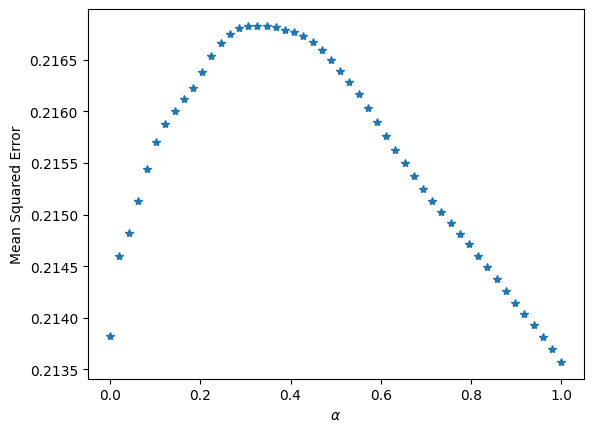

In [64]:
# Create a list of the cv_errors
cv_errs = gsLasso.cv_results_['mean_test_score']

# Plot the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')

# Display the graph
plt.show()

In [69]:
lassoReg = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha=0.35 * X_train.shape[0]))
lassoReg.fit(X_train, y_train)

var = X.columns
val_ols = olsReg.params.tolist()
val_lasso = lassoReg['lasso'].coef_

coef_comp=pd.DataFrame(
    {'var': var,
     'val_ols': val_ols,
     'val_lasso': val_lasso})

print(val_lasso)

[ 0.  0.  0.  0.  0.  0. -0.  0. -0. -0.  0.  0. -0. -0.  0.  0.  0.  0.
  0. -0. -0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0.  0.  0. -0. -0. -0.
  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0. -0. -0.  0. -0.  0.  0.  0.
  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0.
  0.  0. -0. -0.  0. -0. -0.  0. -0. -0.  0.  0.  0. -0.  0.  0.  0.  0.
  0.  0. -0. -0.  0.]


## Cluster Analysis